In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
import sys
import platform
import logging
import argparse
import trino
import io
import boto3
from itertools import islice
from datetime import datetime, date, timedelta
import pendulum
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
# Add parent directory to path
repo_path = '/Users/apple/Documents/naarni/repo/dview-naarni-data-platform'
# repo_path = '/home/notebook/prod/nelson/dview-naarni-data-platform'
sys.path.append(os.path.join(repo_path, 'tasks'))

# Import necessary files and its respective functions
from common.db_operations import connect_to_trino, fetch_data_for_day, write_df_to_iceberg,drop_table,execute_query
from common.optimizer_logic import optimize_dataframe_memory

# Import business logic functions
from biz_logic.energy_mileage.energy_mileage_daily_v0 import energy_mileage_stats ,impute_odometer_readings

from biz_logic.energy_consumption.energy_consumption_report import energy_consumption_stats

# Configure basic logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S')

# Print the Python version being used
print(f"Using Python version: {platform.python_version()}")

Using Python version: 3.13.7


In [3]:
# ---- reporting config (edit ONLY this) ----
TABLE_NAME = "can_parsed_output_100"   # <— change only this

# derived (don’t edit)
REPORT_TABLE = f"adhoc.facts_prod.{TABLE_NAME}"
REPORT_S3_LOCATION = f"s3a://naarni-data-lake/aqua/warehouse/facts_prod.db/{TABLE_NAME}/"

In [4]:
date_str = "2025-10-01"  # Date for which data is to be processed

# Parse the date string as a date object
target_date = datetime.strptime(date_str, "%Y-%m-%d").date()

# Create datetime objects for the start and end of the day in IST
ist_start = datetime.combine(target_date, datetime.min.time())
ist_end = ist_start + timedelta(days=3)

# Convert IST to UTC for the database query
# IST is UTC+5:30, so we subtract 5 hours and 30 minutes
utc_start = ist_start - timedelta(hours=5, minutes=30) 
utc_end = ist_end - timedelta(hours=5, minutes=30)

logging.info(f"🔍 Query window (UTC): {utc_start} → {utc_end}")
logging.info(f"🔍 Query window (IST): {ist_start} → {ist_end}")

2025-11-14 15:11:52 - INFO - 🔍 Query window (UTC): 2025-09-30 18:30:00 → 2025-10-03 18:30:00
2025-11-14 15:11:52 - INFO - 🔍 Query window (IST): 2025-10-01 00:00:00 → 2025-10-04 00:00:00


### AC Fault Code:
1. No_Fault
2. Low_Voltage
3. Outside_Temp_Sensor_Fault
4. High_Voltage
5. Exhaust_Temp_Protection
6. Eva_Temp_Sesnor_Fault
7. AC Communication Fail

### AC Status:
1. Start
2. Stop

### TMS Fault Code:
1. No Fault
2. Water_Sensor_Failure
3. Water_Pump_Failure
4. Water_IN_Sensor_Failure
5. Exhaust_Temp_Protection
6. Low_Water_Level_Alarm
7. LV Undervoltage

### TMS Working Mode:
1. Charging_Cooling
2. Fast_Discharge_Cooling
3. Self_Circulation
4. Low_Coolant
5. Off

### B2T TMS Control Cmd:
1. Charging_Cooling
2. Fast_Discharge_Cooling
3. Self_Circulation
4. Off

In [5]:
# query = f"""
# select 
#     id,date(timestamp + interval '5:30' hour to minute) as dateval,count(*) 
# FROM 
#     facts_prod.can_parsed_output_100
# where 
#     id in ('6') and 
#     timestamp >= TIMESTAMP '{utc_start.strftime('%Y-%m-%d %H:%M:%S')}' and
#     timestamp < TIMESTAMP '{utc_end.strftime('%Y-%m-%d %H:%M:%S')}'
# group by 1,2"""

# conn = connect_to_trino(host="analytics.internal.naarni.com",port=443,user="admin",catalog="adhoc",schema="default")

# df = execute_query(conn, f"SELECT * FROM {REPORT_TABLE} LIMIT 5", return_results=True)
# display(df)

In [6]:
def fetch_battery_data(start_date, end_date, vehicle_ids):
    """
    Fetch raw battery data from the database for the specified date range and vehicle IDs.
    
    Args:
        start_date: Start date in 'YYYY-MM-DD' format
        end_date: End date in 'YYYY-MM-DD' format
        vehicle_ids: List of vehicle IDs
        
    Returns:
        Tuple of (df_cpo100, df_can_ac) containing raw data from both tables
    """
    logging.info(f"Fetching raw battery data from {start_date} to {end_date} for vehicles {vehicle_ids}")
    
    # Format vehicle IDs for the query
    vehicle_ids_str = ', '.join([f"'{vid}'" for vid in vehicle_ids])
    
    # Connect to Trino
    # conn = connect_to_trino(host="analytics.internal.naarni.com", port=443, user="admin", catalog="adhoc", schema="default")
    conn = connect_to_trino(host="trino.naarni.internal",port=80,user="admin",catalog="adhoc",schema="default")
    # conn = trino.dbapi.connect(host="trino",port=8080,user="admin",catalog="adhoc",schema="facts_prod")

    # Query for cpo100 data
    cpo100_query = f"""
    SELECT 
        id,timestamp,sequence,number_of_can_ids,number_of_records,percentage_of_can_ids,lowpressureoilpumpfaultcode,lowvoltagedcaclifesignal,batterycoolingstate,
        batterycoolanttemperature,odometerreading,brakepedalpos,ebsredwarningsignal,abs_ebsamberwarningsignal,insulation_status,insulation__value,lifesignalofinsulation,
        output_phase_voltage,output_phase_currant,motor_rpm,motor_torque,motor_temperature,igbt_temperature,mcuself_teststatus,side_door_panel_open_alarm,ignitionstatus,
        brakingsystemmallfunction_alarm,parking_brake_status,front_air_pressure,rear_air_pressure,brake_pad_worn_out_alarm,
        charger_current, charger_voltage, chargingerror_bms, chrargecurrent_request, evcc_error, 
        guna_dcp_temperature,guna_dcm_temperature,gunb_dcp_temperature,gunb_dcm_temperature,--gunc_dcm_temperature, gunc_dcp_temperature,
        batterypackovervoltagealarm,monomerovervoltagealarm,polehightemperaturealarm,batteryhightemperaturealarm,hightempalarmofcharginggun,monomerundervoltagealarm,
        batterypackundervoltagealarm,temperaturedifferencealarm,singlevoltagedifferencealarm,chargingcurrentalarm,dischargecurrentalarm,sochighalarm,soclowalarm,
        bms_fault_code,gun_connection_status,maxavailableshorttermcharging,maxavailableshorttimedischarge,chargingcontactor2positive,chargingcontactor2negative,chargingcontactor1positive,
        batterytotalnegativecontactor,chargingcontactor1negative,pack_negative_contactors_status,bat_soc,bat_voltage,total_battery_current,bmslifesignal,steering_pump_enable_command,
        air_compressor_enable_command,dcdc_enable_command,vcuversioninformation,distancetoempty,accelarationpedal,brake_pedal,vcuself_teststatus,systeminterlockstate,vehiclereadycondition,
        vehicle_speed_vcu,gear_position,autoholdunenable,powertrain_failure_alarm,vcu_fault_code,vehiclecontrollerlife,
        --pack1_cellmax_voltagecellnumber,pack1_cell_max_voltage,pack1_cellminvoltagecellnumber,pack1_cell_min_voltage,
        cellmax_voltagecellnumber,cell_max_voltage,cellminvoltagecellnumber,cell_min_voltage,th_management_sys_working_mode,
        pack1_cellmax_temperature,pack1_maxtemperature_cell_number,pack1_cell_min_temperature,pack1_celltemperature_cellnumber,
        fourinonelifesignal,fourinoneself_teststatus,prechargedcontactorstate,mainmotorcontactor1state,accessorycontactorstatus,
        pre_charge_status,fiveinone_faultcode,airpumpcondition,air_compreesor_temperature,airpumpdcaclifesignal,
        dcdc_statusandfailure,dcdc_out_put_currant,dcdc_out_put_volatge,dcdcbusvoltage,dcdclifesignal,oilpumpcondition,steering_pump_rpm,steeringcontroller_failurealarm,
        pack_temperature1,pack_temperature2,pack_temperature3,pack_temperature4,pack_temperature5,pack_temperature6,pack_temperature7,pack_temperature8,pack_temperature9,pack_temperature10,
        pack_temperature11,pack_temperature12,pack_temperature13,pack_temperature14,pack_temperature15,pack_temperature16,pack_temperature17,pack_temperature18,pack_temperature19,pack_temperature20,
        pack_temperature21,pack_temperature22,pack_temperature23,pack_temperature24,pack_temperature25,pack_temperature26,pack_temperature27,pack_temperature28,pack_temperature29,pack_temperature30,
        pack_temperature31,pack_temperature32,pack_temperature33,pack_temperature34,pack_temperature35,pack_temperature36,pack_temperature37,pack_temperature38,pack_temperature39,pack_temperature40,
        pack_temperature41,pack_temperature42,pack_temperature43,pack_temperature44,pack_temperature45,pack_temperature46,pack_temperature47,pack_temperature48,pack_temperature49,pack_temperature50,
        pack_temperature51,pack_temperature52,pack_temperature53,pack_temperature54,pack_temperature55,pack_temperature56,pack_temperature57,pack_temperature58,pack_temperature59,pack_temperature60,
        pack_temperature61,pack_temperature62,pack_temperature63,pack_temperature64,pack_temperature65,pack_temperature66,pack_temperature67,pack_temperature68,pack_temperature69,pack_temperature70,
        pack_temperature71,pack_temperature72,pack_temperature73,pack_temperature74,pack_temperature75,pack_temperature76,pack_temperature77,pack_temperature78,pack_temperature79,pack_temperature80,
        pack_temperature81,pack_temperature82,pack_temperature83,pack_temperature84,pack_temperature85,pack_temperature86,pack_temperature87,pack_temperature88,pack_temperature89,pack_temperature90,
        pack_temperature91,pack_temperature92,pack_temperature93,pack_temperature94,pack_temperature95,pack_temperature96,pack_temperature97,pack_temperature98,pack_temperature99,pack_temperature100,
        pack_temperature101,pack_temperature102,pack_temperature103,pack_temperature104,pack_temperature105,pack_temperature106,pack_temperature107,pack_temperature108,
        pack_cellvoltage_1,pack_cellvoltage_2,pack_cellvoltage_3,pack_cellvoltage_4,pack_cellvoltage_5,pack_cellvoltage_6,pack_cellvoltage_7,pack_cellvoltage_8,pack_cellvoltage_9,pack_cellvoltage_10,
        pack_cellvoltage_11,pack_cellvoltage_12,pack_cellvoltage_13,pack_cellvoltage_14,pack_cellvoltage_15,pack_cellvoltage_16,pack_cellvoltage_17,pack_cellvoltage_18,pack_cellvoltage_19,pack_cellvoltage_20,
        pack_cellvoltage_21,pack_cellvoltage_22,pack_cellvoltage_23,pack_cellvoltage_24,pack_cellvoltage_25,pack_cellvoltage_26,pack_cellvoltage_27,pack_cellvoltage_28,pack_cellvoltage_29,pack_cellvoltage_30,
        pack_cellvoltage_31,pack_cellvoltage_32,pack_cellvoltage_33,pack_cellvoltage_34,pack_cellvoltage_35,pack_cellvoltage_36,pack_cellvoltage_37,pack_cellvoltage_38,pack_cellvoltage_39,pack_cellvoltage_40,
        pack_cellvoltage_41,pack_cellvoltage_42,pack_cellvoltage_43,pack_cellvoltage_44,pack_cellvoltage_45,pack_cellvoltage_46,pack_cellvoltage_47,pack_cellvoltage_48,pack_cellvoltage_49,pack_cellvoltage_50,
        pack_cellvoltage_51,pack_cellvoltage_52,pack_cellvoltage_53,pack_cellvoltage_54,pack_cellvoltage_55,pack_cellvoltage_56,pack_cellvoltage_57,pack_cellvoltage_58,pack_cellvoltage_59,pack_cellvoltage_60,
        pack_cellvoltage_61,pack_cellvoltage_62,pack_cellvoltage_63,pack_cellvoltage_64,pack_cellvoltage_65,pack_cellvoltage_66,pack_cellvoltage_67,pack_cellvoltage_68,pack_cellvoltage_69,pack_cellvoltage_70,
        pack_cellvoltage_71,pack_cellvoltage_72,pack_cellvoltage_73,pack_cellvoltage_74,pack_cellvoltage_75,pack_cellvoltage_76,pack_cellvoltage_77,pack_cellvoltage_78,pack_cellvoltage_79,pack_cellvoltage_80,
        pack_cellvoltage_81,pack_cellvoltage_82,pack_cellvoltage_83,pack_cellvoltage_84,pack_cellvoltage_85,pack_cellvoltage_86,pack_cellvoltage_87,pack_cellvoltage_88,pack_cellvoltage_89,pack_cellvoltage_90,
        pack_cellvoltage_91,pack_cellvoltage_92,pack_cellvoltage_93,pack_cellvoltage_94,pack_cellvoltage_95,pack_cellvoltage_96,pack_cellvoltage_97,pack_cellvoltage_98,pack_cellvoltage_99,pack_cellvoltage_100,
        pack_cellvoltage_101,pack_cellvoltage_102,pack_cellvoltage_103,pack_cellvoltage_104,pack_cellvoltage_105,pack_cellvoltage_106,pack_cellvoltage_107,pack_cellvoltage_108,pack_cellvoltage_109,pack_cellvoltage_110,
        pack_cellvoltage_111,pack_cellvoltage_112,pack_cellvoltage_113,pack_cellvoltage_114,pack_cellvoltage_115,pack_cellvoltage_116,pack_cellvoltage_117,pack_cellvoltage_118,pack_cellvoltage_119,pack_cellvoltage_120,
        pack_cellvoltage_121,pack_cellvoltage_122,pack_cellvoltage_123,pack_cellvoltage_124,pack_cellvoltage_125,pack_cellvoltage_126,pack_cellvoltage_127,pack_cellvoltage_128,pack_cellvoltage_129,pack_cellvoltage_130,
        pack_cellvoltage_131,pack_cellvoltage_132,pack_cellvoltage_133,pack_cellvoltage_134,pack_cellvoltage_135,pack_cellvoltage_136,pack_cellvoltage_137,pack_cellvoltage_138,pack_cellvoltage_139,pack_cellvoltage_140,
        pack_cellvoltage_141,pack_cellvoltage_142,pack_cellvoltage_143,pack_cellvoltage_144,pack_cellvoltage_145,pack_cellvoltage_146,pack_cellvoltage_147,pack_cellvoltage_148,pack_cellvoltage_149,pack_cellvoltage_150,
        pack_cellvoltage_151,pack_cellvoltage_152,pack_cellvoltage_153,pack_cellvoltage_154,pack_cellvoltage_155,pack_cellvoltage_156,pack_cellvoltage_157,pack_cellvoltage_158,pack_cellvoltage_159,pack_cellvoltage_160,
        pack_cellvoltage_161,pack_cellvoltage_162,pack_cellvoltage_163,pack_cellvoltage_164,pack_cellvoltage_165,pack_cellvoltage_166,pack_cellvoltage_167,pack_cellvoltage_168,pack_cellvoltage_169,pack_cellvoltage_170,
        pack_cellvoltage_171,pack_cellvoltage_172,pack_cellvoltage_173,pack_cellvoltage_174,pack_cellvoltage_175,pack_cellvoltage_176,pack_cellvoltage_177,pack_cellvoltage_178,pack_cellvoltage_179,pack_cellvoltage_180,
        pack_cellvoltage_181,pack_cellvoltage_182,pack_cellvoltage_183,pack_cellvoltage_184,pack_cellvoltage_185,pack_cellvoltage_186,pack_cellvoltage_187,pack_cellvoltage_188,pack_cellvoltage_189,pack_cellvoltage_190,
        pack_cellvoltage_191,pack_cellvoltage_192,pack_cellvoltage_193,pack_cellvoltage_194,pack_cellvoltage_195,pack_cellvoltage_196,pack_cellvoltage_197,pack_cellvoltage_198,pack_cellvoltage_199,pack_cellvoltage_200,
        pack_cellvoltage_201,pack_cellvoltage_202,pack_cellvoltage_203,pack_cellvoltage_204,pack_cellvoltage_205,pack_cellvoltage_206,pack_cellvoltage_207,pack_cellvoltage_208,pack_cellvoltage_209,pack_cellvoltage_210,
        pack_cellvoltage_211,pack_cellvoltage_212,pack_cellvoltage_213,pack_cellvoltage_214,pack_cellvoltage_215,pack_cellvoltage_216,pack_cellvoltage_217,pack_cellvoltage_218,pack_cellvoltage_219,pack_cellvoltage_220,
        pack_cellvoltage_221,pack_cellvoltage_222,pack_cellvoltage_223,pack_cellvoltage_224,pack_cellvoltage_225,pack_cellvoltage_226,pack_cellvoltage_227,pack_cellvoltage_228,pack_cellvoltage_229,pack_cellvoltage_230,
        pack_cellvoltage_231,pack_cellvoltage_232,pack_cellvoltage_233,pack_cellvoltage_234,pack_cellvoltage_235,pack_cellvoltage_236,pack_cellvoltage_237,pack_cellvoltage_238,pack_cellvoltage_239,pack_cellvoltage_240,
        pack_cellvoltage_241,pack_cellvoltage_242,pack_cellvoltage_243,pack_cellvoltage_244,pack_cellvoltage_245,pack_cellvoltage_246,pack_cellvoltage_247,pack_cellvoltage_248,pack_cellvoltage_249,pack_cellvoltage_250,
        pack_cellvoltage_251,pack_cellvoltage_252,pack_cellvoltage_253,pack_cellvoltage_254,pack_cellvoltage_255,pack_cellvoltage_256,pack_cellvoltage_257,pack_cellvoltage_258,pack_cellvoltage_259,pack_cellvoltage_260,
        pack_cellvoltage_261,pack_cellvoltage_262,pack_cellvoltage_263,pack_cellvoltage_264,pack_cellvoltage_265,pack_cellvoltage_266,pack_cellvoltage_267,pack_cellvoltage_268,pack_cellvoltage_269,pack_cellvoltage_270,
        pack_cellvoltage_271,pack_cellvoltage_272,pack_cellvoltage_273,pack_cellvoltage_274,pack_cellvoltage_275,pack_cellvoltage_276,pack_cellvoltage_277,pack_cellvoltage_278,pack_cellvoltage_279,pack_cellvoltage_280,
        pack_cellvoltage_281,pack_cellvoltage_282,pack_cellvoltage_283,pack_cellvoltage_284,pack_cellvoltage_285,pack_cellvoltage_286,pack_cellvoltage_287,pack_cellvoltage_288,pack_cellvoltage_289,pack_cellvoltage_290,
        pack_cellvoltage_291,pack_cellvoltage_292,pack_cellvoltage_293,pack_cellvoltage_294,pack_cellvoltage_295,pack_cellvoltage_296,pack_cellvoltage_297,pack_cellvoltage_298,pack_cellvoltage_299,pack_cellvoltage_300,
        pack_cellvoltage_301,pack_cellvoltage_302,pack_cellvoltage_303,pack_cellvoltage_304,pack_cellvoltage_305,pack_cellvoltage_306,pack_cellvoltage_307,pack_cellvoltage_308,pack_cellvoltage_309,pack_cellvoltage_310,
        pack_cellvoltage_311,pack_cellvoltage_312,pack_cellvoltage_313,pack_cellvoltage_314,pack_cellvoltage_315,pack_cellvoltage_316,pack_cellvoltage_317,pack_cellvoltage_318,pack_cellvoltage_319,pack_cellvoltage_320,
        pack_cellvoltage_321,pack_cellvoltage_322,pack_cellvoltage_323,pack_cellvoltage_324,pack_cellvoltage_325,pack_cellvoltage_326,pack_cellvoltage_327,pack_cellvoltage_328,pack_cellvoltage_329,pack_cellvoltage_330,
        pack_cellvoltage_331,pack_cellvoltage_332,pack_cellvoltage_333,pack_cellvoltage_334,pack_cellvoltage_335,pack_cellvoltage_336,pack_cellvoltage_337,pack_cellvoltage_338,pack_cellvoltage_339,pack_cellvoltage_340,
        pack_cellvoltage_341,pack_cellvoltage_342,pack_cellvoltage_343,pack_cellvoltage_344,pack_cellvoltage_345,pack_cellvoltage_346,pack_cellvoltage_347,pack_cellvoltage_348,pack_cellvoltage_349,pack_cellvoltage_350,
        pack_cellvoltage_351,pack_cellvoltage_352,pack_cellvoltage_353,pack_cellvoltage_354,pack_cellvoltage_355,pack_cellvoltage_356,pack_cellvoltage_357,pack_cellvoltage_358,pack_cellvoltage_359,pack_cellvoltage_360,
        pack_cellvoltage_361,pack_cellvoltage_362,pack_cellvoltage_363,pack_cellvoltage_364,pack_cellvoltage_365,pack_cellvoltage_366,pack_cellvoltage_367,pack_cellvoltage_368,pack_cellvoltage_369,pack_cellvoltage_370,
        pack_cellvoltage_371,pack_cellvoltage_372,pack_cellvoltage_373,pack_cellvoltage_374,pack_cellvoltage_375,pack_cellvoltage_376,pack_cellvoltage_377,pack_cellvoltage_378,pack_cellvoltage_379,pack_cellvoltage_380
        pack_cellvoltage_381,pack_cellvoltage_382,pack_cellvoltage_383,pack_cellvoltage_384,pack_cellvoltage_385,pack_cellvoltage_386,pack_cellvoltage_387,pack_cellvoltage_388,pack_cellvoltage_389,pack_cellvoltage_390,
        pack_cellvoltage_391,pack_cellvoltage_392,pack_cellvoltage_393,pack_cellvoltage_394,pack_cellvoltage_395,pack_cellvoltage_396,pack_cellvoltage_397,pack_cellvoltage_398,pack_cellvoltage_399,pack_cellvoltage_400,
        pack_cellvoltage_401,pack_cellvoltage_402,pack_cellvoltage_403,pack_cellvoltage_404,pack_cellvoltage_405,pack_cellvoltage_406,pack_cellvoltage_407,pack_cellvoltage_408,pack_cellvoltage_409,pack_cellvoltage_410,
        pack_cellvoltage_411,pack_cellvoltage_412,pack_cellvoltage_413,pack_cellvoltage_414,pack_cellvoltage_415,pack_cellvoltage_416,pack_cellvoltage_417,pack_cellvoltage_418,pack_cellvoltage_419,pack_cellvoltage_420,
        pack_cellvoltage_421,pack_cellvoltage_422,pack_cellvoltage_423,pack_cellvoltage_424,pack_cellvoltage_425,pack_cellvoltage_426,pack_cellvoltage_427,pack_cellvoltage_428,pack_cellvoltage_429,pack_cellvoltage_430,
        pack_cellvoltage_431,pack_cellvoltage_432,pack_cellvoltage_433,pack_cellvoltage_434,pack_cellvoltage_435,pack_cellvoltage_436,pack_cellvoltage_437,pack_cellvoltage_438,pack_cellvoltage_439,pack_cellvoltage_440,
        pack_cellvoltage_441,pack_cellvoltage_442,pack_cellvoltage_443,pack_cellvoltage_444,pack_cellvoltage_445,pack_cellvoltage_446,pack_cellvoltage_447,pack_cellvoltage_448,pack_cellvoltage_449,pack_cellvoltage_450,
        pack_cellvoltage_451,pack_cellvoltage_452,pack_cellvoltage_453,pack_cellvoltage_454,pack_cellvoltage_455,pack_cellvoltage_456,pack_cellvoltage_457,pack_cellvoltage_458,pack_cellvoltage_459,pack_cellvoltage_460,
        pack_cellvoltage_461,pack_cellvoltage_462,pack_cellvoltage_463,pack_cellvoltage_464,pack_cellvoltage_465,pack_cellvoltage_466,pack_cellvoltage_467,pack_cellvoltage_468,pack_cellvoltage_469,pack_cellvoltage_470,
        pack_cellvoltage_471,pack_cellvoltage_472,pack_cellvoltage_473,pack_cellvoltage_474,pack_cellvoltage_475,pack_cellvoltage_476,pack_cellvoltage_477,pack_cellvoltage_478,pack_cellvoltage_479,pack_cellvoltage_480,
        pack_cellvoltage_481,pack_cellvoltage_482,pack_cellvoltage_483,pack_cellvoltage_484,pack_cellvoltage_485,pack_cellvoltage_486,pack_cellvoltage_487,pack_cellvoltage_488,pack_cellvoltage_489,pack_cellvoltage_490,
        pack_cellvoltage_491,pack_cellvoltage_492,pack_cellvoltage_493,pack_cellvoltage_494,pack_cellvoltage_495,pack_cellvoltage_496,pack_cellvoltage_497,pack_cellvoltage_498,pack_cellvoltage_499,pack_cellvoltage_500,
        pack_cellvoltage_501,pack_cellvoltage_502,pack_cellvoltage_503,pack_cellvoltage_504,pack_cellvoltage_505,pack_cellvoltage_506,pack_cellvoltage_507,pack_cellvoltage_508,pack_cellvoltage_509,pack_cellvoltage_510,
        pack_cellvoltage_511,pack_cellvoltage_512,pack_cellvoltage_513,pack_cellvoltage_514,pack_cellvoltage_515,pack_cellvoltage_516,pack_cellvoltage_517,pack_cellvoltage_518,pack_cellvoltage_519,pack_cellvoltage_520,
        pack_cellvoltage_521,pack_cellvoltage_522,pack_cellvoltage_523,pack_cellvoltage_524,pack_cellvoltage_525,pack_cellvoltage_526,pack_cellvoltage_527,pack_cellvoltage_528,pack_cellvoltage_529,pack_cellvoltage_530,
        pack_cellvoltage_531,pack_cellvoltage_532,pack_cellvoltage_533,pack_cellvoltage_534,pack_cellvoltage_535,pack_cellvoltage_536,pack_cellvoltage_537,pack_cellvoltage_538,pack_cellvoltage_539,pack_cellvoltage_540,
        pack_cellvoltage_541,pack_cellvoltage_542,pack_cellvoltage_543,pack_cellvoltage_544,pack_cellvoltage_545,pack_cellvoltage_546,pack_cellvoltage_547,pack_cellvoltage_548,pack_cellvoltage_549,pack_cellvoltage_550,
        pack_cellvoltage_551,pack_cellvoltage_552,pack_cellvoltage_553,pack_cellvoltage_554,pack_cellvoltage_555,pack_cellvoltage_556,pack_cellvoltage_557,pack_cellvoltage_558,pack_cellvoltage_559,pack_cellvoltage_560,
        pack_cellvoltage_561,pack_cellvoltage_562,pack_cellvoltage_563,pack_cellvoltage_564,pack_cellvoltage_565,pack_cellvoltage_566,pack_cellvoltage_567,pack_cellvoltage_568,pack_cellvoltage_569,pack_cellvoltage_570,
        pack_cellvoltage_571,pack_cellvoltage_572,pack_cellvoltage_573,pack_cellvoltage_574,pack_cellvoltage_575,pack_cellvoltage_576       
    FROM 
        facts_prod.can_parsed_output_all
    WHERE
        id in ({vehicle_ids_str})
        and dt between DATE('{start_date}') AND DATE('{end_date}')
    """
    # Execute queries and fetch data
    cur = conn.cursor()

    # Fetch cpo100 data
    cur.execute(cpo100_query)
    cpo100_columns = [desc[0] for desc in cur.description]
    cpo100_rows = cur.fetchall()
    df_cpo100 = pd.DataFrame(cpo100_rows, columns=cpo100_columns)

    df_cpo100['ts_ist'] = (pd.to_datetime(df_cpo100['timestamp'], utc=True).dt.tz_convert('Asia/Kolkata'))

    logging.info(f"Done Fetching data.")
    logging.info(f"Retrieved {len(df_cpo100)} cpo100 records from the database.")
    
    # Close connections
    cur.close()
    conn.close()
    
    return df_cpo100

In [7]:
def get_all_battery_data(start_date, end_date, vehicle_ids):
    """
    Fetch and process all battery data for the specified date range and vehicle IDs.
    
    Args:
        start_date: Start date in 'YYYY-MM-DD' format
        end_date: End date in 'YYYY-MM-DD' format
        vehicle_ids: List of vehicle IDs
        
    Returns:
        DataFrame with battery data
    """
    # Fetch raw data
    df_cpo100 = fetch_battery_data(start_date, end_date, vehicle_ids)
    
    # Process the data
    # result_df, df_cpo100_processed, df_can_ac_processed = process_battery_data(df_cpo100, df_can_ac)

    return df_cpo100

In [8]:
df_cpo100 = get_all_battery_data(utc_start.strftime("%Y-%m-%d"), utc_end.strftime("%Y-%m-%d"), ['18'])

2025-11-14 15:11:52 - INFO - Fetching raw battery data from 2025-09-30 to 2025-10-03 for vehicles ['18']
2025-11-14 15:11:52 - INFO - 🔌 STEP 1: Connecting to Trino...
2025-11-14 15:11:52 - INFO - ✅ STEP 1: Connected to Trino
2025-11-14 15:13:43 - INFO - Done Fetching data.
2025-11-14 15:13:43 - INFO - Retrieved 231180 cpo100 records from the database.


In [9]:
df_cpo100 = df_cpo100[(df_cpo100.timestamp >= utc_start) & (df_cpo100.timestamp <= utc_end)].copy()
print('Timestamp in UTC:',df_cpo100.timestamp.min(),df_cpo100.timestamp.max())
print('Timestamp in IST:',df_cpo100.ts_ist.min(),df_cpo100.ts_ist.max())

Timestamp in UTC: 2025-09-30 18:30:02.731000 2025-10-03 18:29:57.649000
Timestamp in IST: 2025-10-01 00:00:02.731000+05:30 2025-10-03 23:59:57.649000+05:30


In [10]:
display(df_cpo100.head(10))

,id,timestamp,sequence,number_of_can_ids,number_of_records,percentage_of_can_ids,lowpressureoilpumpfaultcode,lowvoltagedcaclifesignal,batterycoolingstate,batterycoolanttemperature,odometerreading,brakepedalpos,ebsredwarningsignal,abs_ebsamberwarningsignal,insulation_status,insulation__value,lifesignalofinsulation,output_phase_voltage,output_phase_currant,motor_rpm,motor_torque,motor_temperature,igbt_temperature,mcuself_teststatus,side_door_panel_open_alarm,ignitionstatus,brakingsystemmallfunction_alarm,parking_brake_status,front_air_pressure,rear_air_pressure,brake_pad_worn_out_alarm,charger_current,charger_voltage,chargingerror_bms,chrargecurrent_request,evcc_error,guna_dcp_temperature,guna_dcm_temperature,gunb_dcp_temperature,gunb_dcm_temperature,batterypackovervoltagealarm,monomerovervoltagealarm,polehightemperaturealarm,batteryhightemperaturealarm,hightempalarmofcharginggun,monomerundervoltagealarm,batterypackundervoltagealarm,temperaturedifferencealarm,singlevoltagedifferencealarm,chargingcurrentalarm,dischargecurrentalarm,sochighalarm,soclowalarm,bms_fault_code,gun_connection_status,maxavailableshorttermcharging,maxavailableshorttimedischarge,chargingcontactor2positive,chargingcontactor2negative,chargingcontactor1positive,batterytotalnegativecontactor,chargingcontactor1negative,pack_negative_contactors_status,bat_soc,bat_voltage,total_battery_current,bmslifesignal,steering_pump_enable_command,air_compressor_enable_command,dcdc_enable_command,vcuversioninformation,distancetoempty,accelarationpedal,brake_pedal,vcuself_teststatus,systeminterlockstate,vehiclereadycondition,vehicle_speed_vcu,gear_position,autoholdunenable,powertrain_failure_alarm,vcu_fault_code,vehiclecontrollerlife,cellmax_voltagecellnumber,cell_max_voltage,cellminvoltagecellnumber,cell_min_voltage,th_management_sys_working_mode,pack1_cellmax_temperature,pack1_maxtemperature_cell_number,pack1_cell_min_temperature,pack1_celltemperature_cellnumber,fourinonelifesignal,fourinoneself_teststatus,prechargedcontactorstate,mainmotorcontactor1state,accessorycontactorstatus,pre_charge_status,fiveinone_faultcode,airpumpcondition,air_compreesor_temperature,airpumpdcaclifesignal,dcdc_statusandfailure,dcdc_out_put_currant,dcdc_out_put_volatge,dcdcbusvoltage,dcdclifesignal,oilpumpcondition,steering_pump_rpm,steeringcontroller_failurealarm,pack_temperature1,pack_temperature2,pack_temperature3,pack_temperature4,pack_temperature5,pack_temperature6,pack_temperature7,pack_temperature8,pack_temperature9,pack_temperature10,pack_temperature11,pack_temperature12,pack_temperature13,pack_temperature14,pack_temperature15,pack_temperature16,pack_temperature17,pack_temperature18,pack_temperature19,pack_temperature20,pack_temperature21,pack_temperature22,pack_temperature23,pack_temperature24,pack_temperature25,pack_temperature26,pack_temperature27,pack_temperature28,pack_temperature29,pack_temperature30,pack_temperature31,pack_temperature32,pack_temperature33,pack_temperature34,pack_temperature35,pack_temperature36,pack_temperature37,pack_temperature38,pack_temperature39,pack_temperature40,pack_temperature41,pack_temperature42,pack_temperature43,pack_temperature44,pack_temperature45,pack_temperature46,pack_temperature47,pack_temperature48,pack_temperature49,pack_temperature50,pack_temperature51,pack_temperature52,pack_temperature53,pack_temperature54,pack_temperature55,pack_temperature56,pack_temperature57,pack_temperature58,pack_temperature59,pack_temperature60,pack_temperature61,pack_temperature62,pack_temperature63,pack_temperature64,pack_temperature65,pack_temperature66,pack_temperature67,pack_temperature68,pack_temperature69,pack_temperature70,pack_temperature71,pack_temperature72,pack_temperature73,pack_temperature74,pack_temperature75,pack_temperature76,pack_temperature77,pack_temperature78,pack_temperature79,pack_temperature80,pack_temperature81,pack_temperature82,pack_temperature83,pack_temperature84,pack_temperature85,pack_temperature86,pack_temperature87,pack_temperature88,pack

In [11]:
df_cpo100.lowvoltagedcaclifesignal.describe()

count    137832.000000
mean        127.404006
std          73.869392
min           0.000000
25%          64.000000
50%         127.000000
75%         191.000000
max         255.000000
Name: lowvoltagedcaclifesignal, dtype: float64

Total temperature columns found: 108

Missingness summary:
       missing_percent
count       108.000000
mean         89.002963
std           6.536464
min          85.080000
25%          85.120000
50%          85.140000
75%         100.000000
max         100.000000

Highest missingness:
                  column  missing_percent
107  pack_temperature108            100.0
86    pack_temperature87            100.0
91    pack_temperature92            100.0
90    pack_temperature91            100.0
89    pack_temperature90            100.0
88    pack_temperature89            100.0
93    pack_temperature94            100.0
94    pack_temperature95            100.0
95    pack_temperature96            100.0
96    pack_temperature97            100.0

Lowest missingness:
                column  missing_percent
0    pack_temperature1            85.08
1    pack_temperature2            85.08
2    pack_temperature3            85.08
3    pack_temperature4            85.08
4    pack_temperature5       

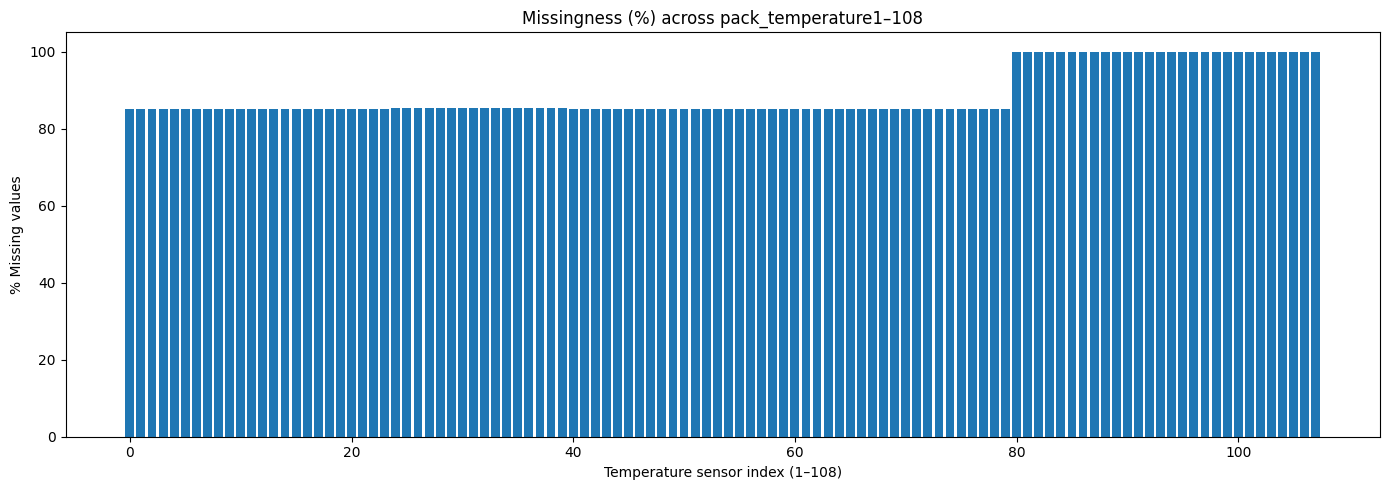

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# --- focus on the 108 temperature columns ---
temp_cols = sorted(
    [c for c in df_cpo100.columns if c.startswith("pack_temperature")],
    key=lambda x: int(x.replace("pack_temperature", ""))
)

# --- calculate % of missing values per column ---
missingness = df_cpo100[temp_cols].isna().mean() * 100  # percentage of NaN per column
missing_df = pd.DataFrame({
    "column": temp_cols,
    "missing_percent": missingness.round(2)
}).reset_index(drop=True)

# --- basic stats ---
print("Total temperature columns found:", len(temp_cols))
print("\nMissingness summary:")
print(missing_df.describe())

# --- top/bottom few columns ---
print("\nHighest missingness:")
print(missing_df.sort_values("missing_percent", ascending=False).head(10))
print("\nLowest missingness:")
print(missing_df.sort_values("missing_percent", ascending=True).head(10))

# --- visualize ---
plt.figure(figsize=(14, 5))
plt.bar(range(len(temp_cols)), missingness)
plt.title("Missingness (%) across pack_temperature1–108")
plt.xlabel("Temperature sensor index (1–108)")
plt.ylabel("% Missing values")
plt.tight_layout()
plt.show()


In [13]:
df_cpo100.head()

,id,timestamp,sequence,number_of_can_ids,number_of_records,percentage_of_can_ids,lowpressureoilpumpfaultcode,lowvoltagedcaclifesignal,batterycoolingstate,batterycoolanttemperature,odometerreading,brakepedalpos,ebsredwarningsignal,abs_ebsamberwarningsignal,insulation_status,insulation__value,lifesignalofinsulation,output_phase_voltage,output_phase_currant,motor_rpm,motor_torque,motor_temperature,igbt_temperature,mcuself_teststatus,side_door_panel_open_alarm,ignitionstatus,brakingsystemmallfunction_alarm,parking_brake_status,front_air_pressure,rear_air_pressure,brake_pad_worn_out_alarm,charger_current,charger_voltage,chargingerror_bms,chrargecurrent_request,evcc_error,guna_dcp_temperature,guna_dcm_temperature,gunb_dcp_temperature,gunb_dcm_temperature,batterypackovervoltagealarm,monomerovervoltagealarm,polehightemperaturealarm,batteryhightemperaturealarm,hightempalarmofcharginggun,monomerundervoltagealarm,batterypackundervoltagealarm,temperaturedifferencealarm,singlevoltagedifferencealarm,chargingcurrentalarm,dischargecurrentalarm,sochighalarm,soclowalarm,bms_fault_code,gun_connection_status,maxavailableshorttermcharging,maxavailableshorttimedischarge,chargingcontactor2positive,chargingcontactor2negative,chargingcontactor1positive,batterytotalnegativecontactor,chargingcontactor1negative,pack_negative_contactors_status,bat_soc,bat_voltage,total_battery_current,bmslifesignal,steering_pump_enable_command,air_compressor_enable_command,dcdc_enable_command,vcuversioninformation,distancetoempty,accelarationpedal,brake_pedal,vcuself_teststatus,systeminterlockstate,vehiclereadycondition,vehicle_speed_vcu,gear_position,autoholdunenable,powertrain_failure_alarm,vcu_fault_code,vehiclecontrollerlife,cellmax_voltagecellnumber,cell_max_voltage,cellminvoltagecellnumber,cell_min_voltage,th_management_sys_working_mode,pack1_cellmax_temperature,pack1_maxtemperature_cell_number,pack1_cell_min_temperature,pack1_celltemperature_cellnumber,fourinonelifesignal,fourinoneself_teststatus,prechargedcontactorstate,mainmotorcontactor1state,accessorycontactorstatus,pre_charge_status,fiveinone_faultcode,airpumpcondition,air_compreesor_temperature,airpumpdcaclifesignal,dcdc_statusandfailure,dcdc_out_put_currant,dcdc_out_put_volatge,dcdcbusvoltage,dcdclifesignal,oilpumpcondition,steering_pump_rpm,steeringcontroller_failurealarm,pack_temperature1,pack_temperature2,pack_temperature3,pack_temperature4,pack_temperature5,pack_temperature6,pack_temperature7,pack_temperature8,pack_temperature9,pack_temperature10,pack_temperature11,pack_temperature12,pack_temperature13,pack_temperature14,pack_temperature15,pack_temperature16,pack_temperature17,pack_temperature18,pack_temperature19,pack_temperature20,pack_temperature21,pack_temperature22,pack_temperature23,pack_temperature24,pack_temperature25,pack_temperature26,pack_temperature27,pack_temperature28,pack_temperature29,pack_temperature30,pack_temperature31,pack_temperature32,pack_temperature33,pack_temperature34,pack_temperature35,pack_temperature36,pack_temperature37,pack_temperature38,pack_temperature39,pack_temperature40,pack_temperature41,pack_temperature42,pack_temperature43,pack_temperature44,pack_temperature45,pack_temperature46,pack_temperature47,pack_temperature48,pack_temperature49,pack_temperature50,pack_temperature51,pack_temperature52,pack_temperature53,pack_temperature54,pack_temperature55,pack_temperature56,pack_temperature57,pack_temperature58,pack_temperature59,pack_temperature60,pack_temperature61,pack_temperature62,pack_temperature63,pack_temperature64,pack_temperature65,pack_temperature66,pack_temperature67,pack_temperature68,pack_temperature69,pack_temperature70,pack_temperature71,pack_temperature72,pack_temperature73,pack_temperature74,pack_temperature75,pack_temperature76,pack_temperature77,pack_temperature78,pack_temperature79,pack_temperature80,pack_temperature81,pack_temperature82,pack_temperature83,pack_temperature84,pack_temperature85,pack_temperature86,pack_temperature87,pack_temperature88,pack

Total pack cell voltage columns found: 575

Missingness summary for pack cell voltages:
       missing_percent
count       575.000000
mean         98.466470
std           0.130054
min          98.410000
25%          98.440000
50%          98.460000
75%          98.470000
max         100.000000

Highest missingness:
                   column  missing_percent
80    pack_cellvoltage_81           100.00
83    pack_cellvoltage_84           100.00
82    pack_cellvoltage_83           100.00
81    pack_cellvoltage_82           100.00
462  pack_cellvoltage_464            98.53
460  pack_cellvoltage_462            98.53
459  pack_cellvoltage_461            98.53
461  pack_cellvoltage_463            98.53
556  pack_cellvoltage_558            98.50
371  pack_cellvoltage_372            98.50

Lowest missingness:
                   column  missing_percent
79    pack_cellvoltage_80            98.41
78    pack_cellvoltage_79            98.41
156  pack_cellvoltage_157            98.41
157  pack_cellvol

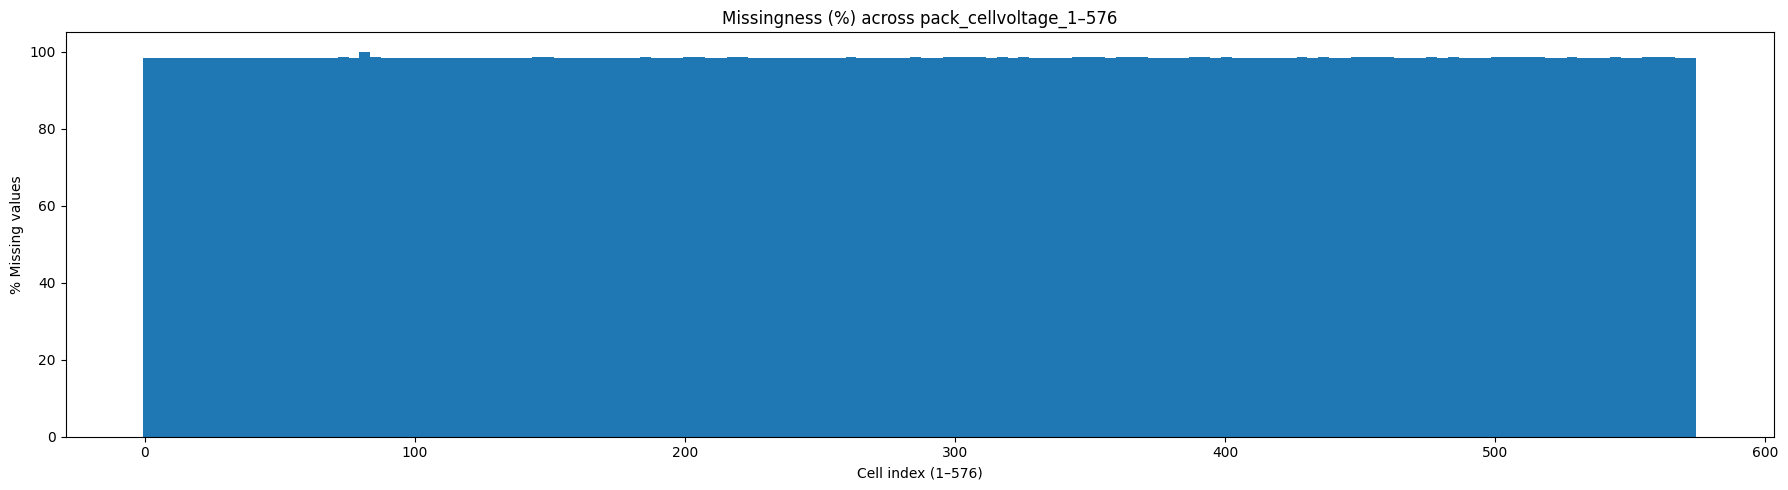

In [14]:
# --- identify all 576 voltage columns ---
voltage_cols = sorted(
    [c for c in df_cpo100.columns if c.startswith("pack_cellvoltage_")],
    key=lambda x: int(x.replace("pack_cellvoltage_", ""))
)

print("Total pack cell voltage columns found:", len(voltage_cols))

# --- calculate percentage of missing data per column ---
missingness_voltage = df_cpo100[voltage_cols].isna().mean() * 100
missing_df_voltage = pd.DataFrame({
    "column": voltage_cols,
    "missing_percent": missingness_voltage.round(2)
}).reset_index(drop=True)

# --- summary output ---
print("\nMissingness summary for pack cell voltages:")
print(missing_df_voltage.describe())

print("\nHighest missingness:")
print(missing_df_voltage.sort_values("missing_percent", ascending=False).head(10))

print("\nLowest missingness:")
print(missing_df_voltage.sort_values("missing_percent", ascending=True).head(10))

# --- visualize ---
plt.figure(figsize=(18, 5))
plt.bar(range(len(voltage_cols)), missingness_voltage, width=1)
plt.title("Missingness (%) across pack_cellvoltage_1–576")
plt.xlabel("Cell index (1–576)")
plt.ylabel("% Missing values")
plt.tight_layout()
plt.show()


In [15]:
df_cpo100.ts_ist.min(),df_cpo100.ts_ist.max()

(Timestamp('2025-10-01 00:00:02.731000+0530', tz='Asia/Kolkata'),
 Timestamp('2025-10-03 23:59:57.649000+0530', tz='Asia/Kolkata'))

In [16]:
# df_cpo100[df_cpo100["vehiclereadycondition"]==1].head(10)

In [17]:
# --- prerequisite: df_drive prepared as before ---
# df_drive = df_cpo100[df_cpo100["vehiclereadycondition"] == 1].copy()
df_drive = df_cpo100.copy()
df_drive["timestamp"] = pd.to_datetime(df_drive["timestamp"], errors="coerce")
df_drive = df_drive.sort_values("timestamp").reset_index(drop=True)

# --- segment definitions (8 sensors per segment) ---
temp_cols = sorted([c for c in df_drive.columns if c.startswith("pack_temperature")],key=lambda x: int(x.replace("pack_temperature","")))
temp_cols = temp_cols[:80]  # 🔹 Limit to first 80 sensors with actual data

segment_map = {col: (i // 4) + 1 for i, col in enumerate(temp_cols)}  # 27 segments

# --- tracking structures ---
received_segments = set()
segment_occurrences = []
latest_values = {col: np.nan for col in temp_cols}
pack_complete_intervals = []
current_start = None

for _, row in df_drive.iterrows():
    ts = row["timestamp"]
    valid_sensors = [c for c in temp_cols if pd.notna(row[c])]
    if valid_sensors:
        if current_start is None:
            current_start = ts
        # record which segment indices reported
        new_segments = {segment_map[c] for c in valid_sensors}
        received_segments.update(new_segments)
        segment_occurrences.extend(list(new_segments))

        # update sensor values
        for s in valid_sensors:
            latest_values[s] = row[s]

    if len(received_segments) == len(set(segment_map.values())):
        pack_complete_intervals.append({
            "start_timestamp": current_start,
            "end_timestamp": ts,
            "diff_ts_seconds": (ts - current_start).total_seconds(),
            "seg_observed": len(received_segments),
            "segment_occurrence_count": {seg: segment_occurrences.count(seg) for seg in sorted(set(segment_map.values()))}
        })
        # reset
        received_segments.clear()
        segment_occurrences.clear()
        latest_values = {col: np.nan for col in temp_cols}
        current_start = None

pack_complete_intervals_df = pd.DataFrame(pack_complete_intervals)

# --- compute gap_since_prev ---
if not pack_complete_intervals_df.empty:
    pack_complete_intervals_df["gap_since_prev"] = (
        pack_complete_intervals_df["start_timestamp"]
        - pack_complete_intervals_df["end_timestamp"].shift(1)
    ).dt.total_seconds()

pack_complete_intervals_df.head()


,start_timestamp,end_timestamp,diff_ts_seconds,seg_observed,segment_occurrence_count,gap_since_prev
0,2025-09-30 18:30:05.251,2025-09-30 18:32:46.931,161.68,20,"{1: 4, 2: 4, 3: 8, 4: 8, 5: 7, 6: 7, 7: 5, 8: 5, 9: 8, 10: 8, 11: 1, 12: 1, 13: 5, 14: 5, 15: 9, 16: 9, 17: 5, 18: 5, 19: 5, 20: 5}",NaN
1,2025-09-30 18:32:47.851,2025-09-30 18:32:56.351,8.50,20,"{1: 1, 2: 1, 3: 2, 4: 2, 5: 1, 6: 1, 7: 1, 8: 1, 9: 2, 10: 2, 11: 1, 12: 1, 13: 4, 14: 4, 15: 2, 16: 2, 17: 1, 18: 1, 19: 2, 20: 2}",0.92
2,2025-09-30 18:32:57.351,2025-09-30 18:33:13.691,16.34,20,"{1: 5, 2: 5, 3: 3, 4: 3, 5: 1, 6: 1, 7: 1, 8: 1, 9: 2, 10: 2, 11: 2, 12: 2, 13: 3, 14: 3, 15: 2, 16: 2, 17: 3, 18: 3, 19: 3, 20: 3}",1.00
3,2025-09-30 18:33:14.591,2025-09-30 18:33:33.551,18.96,20,"{1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7: 4, 8: 4, 9: 2, 10: 2, 11: 2, 12: 2, 13: 3, 14: 3, 15: 3, 16: 3, 17: 2, 18: 2, 19: 1, 20: 1}",0.90
4,2025-09-30 18:33:34.851,2025-09-30 18:33:53.991,19.14,20,"{1: 5, 2: 5, 3: 1, 4: 1, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2, 11: 2, 12: 2, 13: 4, 14: 4, 15: 1, 16: 1, 17: 3, 18: 3, 19: 1, 20: 1}",1.30


Stefan Louis Insights
1. Aging mechanism in a battery, calendar aging
2. Modularize the entire battery System
3. Passive vs active components
4. Mechanical vs electrochemical components
5. Establish measuring parameters
6. Expected vs the real case scenarios
7. Charging patterns based on "discharge patterns" of the battery.
8. Cell Balancing: Culprit the weakest cell!!!
9. Time taken for cell balancing post
10. Battery life killers: 
    electrolyte standards: charge/dischar rate, absolute energy throughput, 



Examples: Trinueron EV battery chargers

In [18]:
seg_df = pack_complete_intervals_df["segment_occurrence_count"].apply(pd.Series)
if "segment_occurrence_count" not in pack_complete_intervals_df.columns:
    print("Column missing:", [c for c in pack_complete_intervals_df.columns])
else:
    seg_df = pack_complete_intervals_df["segment_occurrence_count"].apply(pd.Series)

# seg_df.columns = [f"segment_{int(c)}_count" for c in seg_df.columns]
pack_complete_intervals_df = pd.concat([pack_complete_intervals_df.drop(columns=["segment_occurrence_count"]), seg_df], axis=1)
pack_complete_intervals_df.head()

,start_timestamp,end_timestamp,diff_ts_seconds,seg_observed,gap_since_prev,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,2025-09-30 18:30:05.251,2025-09-30 18:32:46.931,161.68,20,NaN,4,4,8,8,7,7,5,5,8,8,1,1,5,5,9,9,5,5,5,5
1,2025-09-30 18:32:47.851,2025-09-30 18:32:56.351,8.50,20,0.92,1,1,2,2,1,1,1,1,2,2,1,1,4,4,2,2,1,1,2,2
2,2025-09-30 18:32:57.351,2025-09-30 18:33:13.691,16.34,20,1.00,5,5,3,3,1,1,1,1,2,2,2,2,3,3,2,2,3,3,3,3
3,2025-09-30 18:33:14.591,2025-09-30 18:33:33.551,18.96,20,0.90,1,1,2,2,3,3,4,4,2,2,2,2,3,3,3,3,2,2,1,1
4,2025-09-30 18:33:34.851,2025-09-30 18:33:53.991,19.14,20,1.30,5,5,1,1,2,2,2,2,2,2,2,2,4,4,1,1,3,3,1,1


In [19]:
pack_complete_intervals_df.diff_ts_seconds.describe()

count    11269.000000
mean        21.166019
std         77.768661
min          0.900000
25%          6.439000
50%         10.520000
75%         17.600000
max       3682.035000
Name: diff_ts_seconds, dtype: float64

In [20]:
pack_complete_intervals_df["diff_ts_seconds"].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99,0.995, 0.999])

count    11269.000000
mean        21.166019
std         77.768661
min          0.900000
25%          6.439000
50%         10.520000
75%         17.600000
95%         64.320000
99%        127.032480
99.5%      233.454600
99.9%     1015.867188
max       3682.035000
Name: diff_ts_seconds, dtype: float64

In [21]:
pack_complete_intervals_df[(pack_complete_intervals_df.diff_ts_seconds>275)].diff_ts_seconds.describe()

count      52.000000
mean      836.171250
std       742.196216
min       276.540000
25%       356.602250
50%       524.197000
75%       937.329750
max      3682.035000
Name: diff_ts_seconds, dtype: float64

In [22]:
pack_complete_intervals_df[(pack_complete_intervals_df.diff_ts_seconds>275)]

,start_timestamp,end_timestamp,diff_ts_seconds,seg_observed,gap_since_prev,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
17,2025-09-30 18:36:47.211,2025-09-30 18:42:04.094,316.883,20,1.043,5,5,4,4,1,1,2,2,3,3,4,4,5,5,7,7,5,5,3,3
202,2025-09-30 19:29:09.125,2025-09-30 19:34:01.340,292.215,20,0.959,2,2,2,2,1,1,2,2,2,2,1,1,1,1,3,3,1,1,1,1
1365,2025-09-30 23:24:49.429,2025-09-30 23:31:16.346,386.917,20,2.048,3,3,3,3,3,3,2,2,2,2,2,2,1,1,3,3,1,1,2,2
1688,2025-10-01 00:22:42.894,2025-10-01 00:29:33.008,410.114,20,1.079,4,4,4,4,2,2,3,3,4,4,3,3,1,1,2,2,5,5,5,5
2238,2025-10-01 02:35:42.024,2025-10-01 03:02:46.532,1624.508,20,0.965,2,2,2,2,2,2,4,4,5,5,5,5,3,3,2,2,1,1,1,1
2380,2025-10-01 03:42:49.363,2025-10-01 03:47:52.557,303.194,20,0.780,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,3,3,1,1
2382,2025-10-01 03:48:13.579,2025-10-01 03:54:52.895,399.316,20,3.041,5,5,1,1,2,2,5,5,4,4,7,7,5,5,6,6,2,2,4,4
2715,2025-10-01 05:21:08.743,2025-10-01 05:50:17.443,1748.700,20,1.040,3,3,1,1,1,1,2,2,1,1,1,1,1,1,1,1,1,1,2,2
3146,2025-10-01 07:47:25.192,2025-10-01 07:52:13.901,288.709,20,1.133,1,1,2,2,3,3,1,1,1,1,1,1,1,1,1,1,2,2,3,3
3317,2025-10-01 08:40:34.386,2025-10-01 08:45:14.013,279.627,20,1.131,2,2,3,3,4,4,4,4,2,2,4,4,3,3,2,2,2,2,1,1


In [23]:
pack_complete_intervals_df.diff_ts_seconds.describe()

count    11269.000000
mean        21.166019
std         77.768661
min          0.900000
25%          6.439000
50%         10.520000
75%         17.600000
max       3682.035000
Name: diff_ts_seconds, dtype: float64

In [24]:
pack_complete_intervals_df[(pack_complete_intervals_df.diff_ts_seconds>10) & (pack_complete_intervals_df.diff_ts_seconds<100)].diff_ts_seconds.describe()

count    5713.000000
mean       24.475259
std        18.621292
min        10.019000
25%        12.680000
50%        16.680000
75%        27.843000
max        99.799000
Name: diff_ts_seconds, dtype: float64

In [25]:
len(pack_complete_intervals_df)

11269

In [26]:
pack_complete_intervals_df[(pack_complete_intervals_df.diff_ts_seconds>100) & (pack_complete_intervals_df.diff_ts_seconds<500)].diff_ts_seconds.describe()

count    184.000000
mean     162.534777
std       84.103555
min      100.860000
25%      111.095250
50%      124.746500
75%      176.243500
max      493.378000
Name: diff_ts_seconds, dtype: float64

In [27]:
x = pack_complete_intervals_df["diff_ts_seconds"].dropna()
mean = np.mean(x)
sem = stats.sem(x)  # standard error of the mean
ci = stats.t.interval(0.995, len(x)-1, loc=mean, scale=sem)
print(f"Mean: {mean:.3f} s, 99.5% CI: {ci}")


Mean: 21.166 s, 99.5% CI: (np.float64(19.109204184337713), np.float64(23.222833263528116))


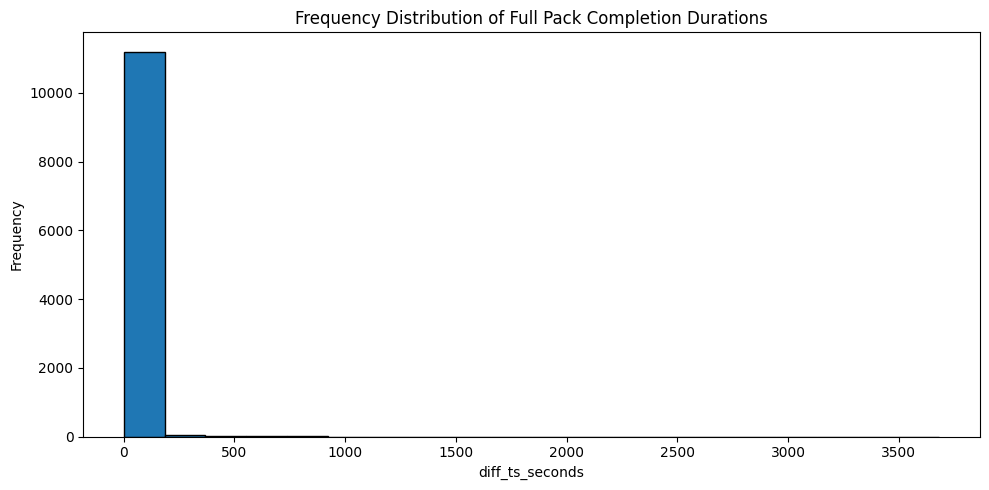

In [28]:
# --- visualize recurring cycle durations ---
plt.figure(figsize=(10,5))
plt.hist(pack_complete_intervals_df.diff_ts_seconds, bins=20, edgecolor='black')
# plt.hist(pack_complete_intervals_df[pack_complete_intervals_df.diff_ts_seconds>300].diff_ts_seconds, bins=20, edgecolor='black')
plt.title("Frequency Distribution of Full Pack Completion Durations")
plt.xlabel("diff_ts_seconds")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [29]:
pack_complete_intervals_df[pack_complete_intervals_df.diff_ts_seconds>300]

,start_timestamp,end_timestamp,diff_ts_seconds,seg_observed,gap_since_prev,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
17,2025-09-30 18:36:47.211,2025-09-30 18:42:04.094,316.883,20,1.043,5,5,4,4,1,1,2,2,3,3,4,4,5,5,7,7,5,5,3,3
1365,2025-09-30 23:24:49.429,2025-09-30 23:31:16.346,386.917,20,2.048,3,3,3,3,3,3,2,2,2,2,2,2,1,1,3,3,1,1,2,2
1688,2025-10-01 00:22:42.894,2025-10-01 00:29:33.008,410.114,20,1.079,4,4,4,4,2,2,3,3,4,4,3,3,1,1,2,2,5,5,5,5
2238,2025-10-01 02:35:42.024,2025-10-01 03:02:46.532,1624.508,20,0.965,2,2,2,2,2,2,4,4,5,5,5,5,3,3,2,2,1,1,1,1
2380,2025-10-01 03:42:49.363,2025-10-01 03:47:52.557,303.194,20,0.780,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,3,3,1,1
2382,2025-10-01 03:48:13.579,2025-10-01 03:54:52.895,399.316,20,3.041,5,5,1,1,2,2,5,5,4,4,7,7,5,5,6,6,2,2,4,4
2715,2025-10-01 05:21:08.743,2025-10-01 05:50:17.443,1748.700,20,1.040,3,3,1,1,1,1,2,2,1,1,1,1,1,1,1,1,1,1,2,2
3440,2025-10-01 09:05:45.275,2025-10-01 09:36:43.955,1858.680,20,1.040,3,3,3,3,4,4,3,3,1,1,3,3,1,1,3,3,3,3,2,2
3553,2025-10-01 09:55:11.466,2025-10-01 10:00:18.354,306.888,20,1.020,3,3,2,2,2,2,4,4,4,4,4,4,4,4,1,1,2,2,4,4
3876,2025-10-01 10:53:10.134,2025-10-01 10:59:54.536,404.402,20,1.080,2,2,4,4,5,5,7,7,7,7,5,5,1,1,3,3,6,6,5,5


In [30]:
mask = pack_complete_intervals_df["diff_ts_seconds"] > 500
high_gap_times = pack_complete_intervals_df.loc[mask, ["start_timestamp", "end_timestamp"]]

# Inspect CAN density and timestamps in those windows
for _, row in high_gap_times.iterrows():
    window = df_cpo100[(df_cpo100["timestamp"] >= row["start_timestamp"]) &
                       (df_cpo100["timestamp"] <= row["end_timestamp"])]
    print(row["start_timestamp"], "–", row["end_timestamp"], f"({len(window)} records), duration: {row['end_timestamp'] - row['start_timestamp']}")
    print(window[["timestamp", "number_of_can_ids", "percentage_of_can_ids"]].describe())

2025-10-01 02:35:42.024000 – 2025-10-01 03:02:46.532000 (19 records), duration: 0 days 00:27:04.508000
                           timestamp  number_of_can_ids  percentage_of_can_ids
count                             19          19.000000              19.000000
mean   2025-10-01 02:40:05.208052992          24.789474              13.185890
min       2025-10-01 02:35:42.024000          17.000000               9.042553
25%    2025-10-01 02:35:47.039000064          23.000000              12.234042
50%       2025-10-01 02:35:51.900000          24.000000              12.765958
75%    2025-10-01 02:35:56.649500160          28.000000              14.893617
max       2025-10-01 03:02:46.532000          31.000000              16.489360
std                              NaN           3.895567               2.072110
2025-10-01 05:21:08.743000 – 2025-10-01 05:50:17.443000 (36 records), duration: 0 days 00:29:08.700000
                           timestamp  number_of_can_ids  percentage_of_can_ids
coun

In [31]:
# Check fraction of NaN temperature sensors during high diff_ts periods
window_stats = []
for _, row in high_gap_times.iterrows():
    window = df_cpo100[(df_cpo100["timestamp"] >= row["start_timestamp"]) &
                       (df_cpo100["timestamp"] <= row["end_timestamp"])]
    null_fraction = window[[c for c in df_cpo100.columns if c.startswith("pack_temperature")]].isna().mean().mean()
    window_stats.append((row["start_timestamp"], row["end_timestamp"], null_fraction))
pd.DataFrame(window_stats, columns=["start_ts", "end_ts", "mean_null_fraction"])


,start_ts,end_ts,mean_null_fraction
0,2025-10-01 02:35:42.024,2025-10-01 03:02:46.532,0.894737
1,2025-10-01 05:21:08.743,2025-10-01 05:50:17.443,0.971193
2,2025-10-01 09:05:45.275,2025-10-01 09:36:43.955,0.998884
3,2025-10-01 14:47:37.319,2025-10-01 14:56:00.487,0.818182
4,2025-10-01 15:48:08.302,2025-10-01 16:01:06.189,0.870370
5,2025-10-01 18:42:45.937,2025-10-01 18:51:11.451,0.863248
6,2025-10-01 20:05:28.281,2025-10-01 20:31:11.848,0.999422
7,2025-10-01 21:01:39.868,2025-10-01 21:14:29.568,0.997347
8,2025-10-01 22:13:00.708,2025-10-01 22:50:11.528,0.999611
9,2025-10-01 22:57:57.788,2025-10-01 23:10:11.048,0.930705


In [32]:
window[["timestamp", "vehiclereadycondition", "gun_connection_status", "ignitionstatus"]]

,timestamp,vehiclereadycondition,gun_connection_status,ignitionstatus
111450,2025-10-03 15:30:24.512,1.0,0.0,1.0
111451,2025-10-03 15:30:25.612,1.0,0.0,1.0
111452,2025-10-03 15:30:26.632,1.0,0.0,1.0
111453,2025-10-03 15:30:27.852,1.0,0.0,1.0
111454,2025-10-03 15:30:29.072,1.0,0.0,NaN
111455,2025-10-03 15:30:30.232,1.0,0.0,1.0
111456,2025-10-03 15:30:31.272,1.0,0.0,1.0
111457,2025-10-03 15:37:59.432,1.0,0.0,1.0
111458,2025-10-03 15:37:59.632,1.0,0.0,1.0
111459,2025-10-03 15:38:00.772,1.0,0.0,1.0


In [33]:
def classify_gap(row):
    window = df_cpo100[(df_cpo100["timestamp"] >= row.start_timestamp) &
                       (df_cpo100["timestamp"] <= row.end_timestamp)]
    null_rate = window.filter(like="pack_temperature").isna().mean().mean()
    can_ids_mean = window["number_of_can_ids"].mean() if "number_of_can_ids" in window else np.nan
    veh_ready = window["vehiclereadycondition"].mode().iloc[0] if "vehiclereadycondition" in window else np.nan
    gun_conn = window["gun_connection_status"].mode().iloc[0] if "gun_connection_status" in window else np.nan
    return pd.Series({"mean_null_rate": null_rate,
                      "mean_can_ids": can_ids_mean,
                      "veh_ready_mode": veh_ready,
                      "gun_conn_mode": gun_conn})

mask = pack_complete_intervals_df["diff_ts_seconds"] > 500
diagnosis = pack_complete_intervals_df.loc[mask].apply(classify_gap, axis=1)
display(diagnosis)


,mean_null_rate,mean_can_ids,veh_ready_mode,gun_conn_mode
2238,0.894737,24.789474,1.0,0.0
2715,0.971193,9.000000,0.0,0.0
3440,0.998884,3.129200,0.0,1.0
4658,0.818182,27.454545,1.0,0.0
4821,0.870370,26.000000,1.0,0.0
5331,0.863248,25.846154,1.0,0.0
5675,0.999422,3.076596,0.0,0.0
5955,0.997347,3.312672,0.0,1.0
6474,0.999611,3.077879,0.0,1.0
6503,0.930705,16.677419,0.0,0.0


In [34]:
df_cpo100.bmslifesignal.describe()

count    149710.000000
mean        127.107287
std          73.965873
min           0.000000
25%          63.000000
50%         127.000000
75%         191.000000
max         255.000000
Name: bmslifesignal, dtype: float64

In [35]:
# assume: df_cpo100 already loaded with 'bmslifesignal' and timestamp columns
# and pack_complete_intervals_df holds the intervals

mask = pack_complete_intervals_df["diff_ts_seconds"] > 500
high_gap_intervals = pack_complete_intervals_df.loc[mask, ["start_timestamp", "end_timestamp"]]

def analyze_bms_activity(row):
    # slice main dataframe for that interval
    window = df_cpo100[(df_cpo100["timestamp"] >= row.start_timestamp) &
                       (df_cpo100["timestamp"] <= row.end_timestamp)]
    
    # compute basic stats
    n_records = len(window)
    can_mean = window["number_of_can_ids"].mean() if "number_of_can_ids" in window else np.nan
    null_rate = window.filter(like="pack_temperature").isna().mean().mean()
    
    if "bmslifesignal" in window:
        unique_vals = window["bmslifesignal"].nunique(dropna=True)
        min_val = window["bmslifesignal"].min()
        max_val = window["bmslifesignal"].max()
        diff_val = (max_val - min_val) if pd.notna(min_val) and pd.notna(max_val) else np.nan
    else:
        unique_vals = min_val = max_val = diff_val = np.nan

    # simple heuristic classification
    if unique_vals <= 1 or pd.isna(unique_vals):
        status = "BMS heartbeat missing / frozen"
    elif diff_val < 5:
        status = "BMS sluggish / intermittent"
    else:
        status = "BMS active but CAN/TMS mute"

    return pd.Series({
        "n_records": n_records,
        "mean_CAN_IDs": can_mean,
        "mean_null_rate": null_rate,
        "bms_unique_vals": unique_vals,
        "bms_min": min_val,
        "bms_max": max_val,
        "bms_diff": diff_val,
        "status_inference": status
    })

bms_diagnostics = high_gap_intervals.apply(analyze_bms_activity, axis=1)
pd.set_option("display.max_colwidth", None)
display(bms_diagnostics)


,n_records,mean_CAN_IDs,mean_null_rate,bms_unique_vals,bms_min,bms_max,bms_diff,status_inference
2238,19,24.789474,0.894737,15,0.0,248.0,248.0,BMS active but CAN/TMS mute
2715,36,9.000000,0.971193,11,0.0,210.0,210.0,BMS active but CAN/TMS mute
3440,1726,3.129200,0.998884,12,1.0,109.0,108.0,BMS active but CAN/TMS mute
4658,11,27.454545,0.818182,11,122.0,223.0,101.0,BMS active but CAN/TMS mute
4821,8,26.000000,0.870370,7,95.0,138.0,43.0,BMS active but CAN/TMS mute
5331,13,25.846154,0.863248,12,10.0,221.0,211.0,BMS active but CAN/TMS mute
5675,1410,3.076596,0.999422,7,0.0,129.0,129.0,BMS active but CAN/TMS mute
5955,726,3.312672,0.997347,11,1.0,164.0,163.0,BMS active but CAN/TMS mute
6474,2093,3.077879,0.999611,6,2.0,193.0,191.0,BMS active but CAN/TMS mute
6503,31,16.677419,0.930705,19,0.0,141.0,141.0,BMS active but CAN/TMS mute


In [36]:
# 0. Parse time, sort
df = df_cpo100.copy()
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df = df.sort_values("timestamp").reset_index(drop=True)

# 1. Find voltage columns (1..380)
volt_cols = sorted(
    [c for c in df.columns if c.startswith("pack_cellvoltage_")],
    key=lambda x: int(x.split("_")[-1])
)
n_cells = len(volt_cols)
assert n_cells >= 1, "No voltage columns found."

# Per-column missing rate
voltage_missing_rate = df[volt_cols].isna().mean().to_frame("missing_rate").sort_values("missing_rate", ascending=False)

# Per-row valid count
df["volt_valid_count"] = df[volt_cols].notna().sum(axis=1)
df["volt_null_frac"] = 1 - (df["volt_valid_count"] / n_cells)

# Correlate coverage with bus health
coverage_corr = df[["volt_valid_count"]].join(
    df[[c for c in ["number_of_can_ids","percentage_of_can_ids","vehiclereadycondition","gun_connection_status"] if c in df]]
).corr()["volt_valid_count"].sort_values(ascending=False)

# Co-missing (pairwise) — summarize strongest pairs (heavy matrix; we don’t print full)
null_mat = df[volt_cols].isna().astype(int)
# For speed, sample rows if huge
sample_idx = np.linspace(0, len(df)-1, min(4000, len(df))).astype(int)
null_corr = null_mat.iloc[sample_idx].corr()
strong_comiss_pairs = (
    null_corr.where(~np.eye(n_cells, dtype=bool))
             .stack().reset_index()
             .rename(columns={"level_0":"cell_a","level_1":"cell_b",0:"null_corr"})
             .query("null_corr > 0.7")
             .sort_values("null_corr", ascending=False)
)
print("Voltage Missing Rate (Top 10):")
display(voltage_missing_rate.head(10))

# Dead columns (all NaN)
dead_cells = [c for c in volt_cols if df[c].notna().sum()==0]

# Stuck / flatliners: very low std or very few unique values
def is_stuck(series, std_eps=1e-4, uniq_max=3):
    s = series.dropna()
    return (s.std(skipna=True) < std_eps) or (s.nunique(dropna=True) <= uniq_max)

stuck_cells = [c for c in volt_cols if is_stuck(df[c], std_eps=1e-4, uniq_max=2)]

# Out-of-range values (typical Li-ion sanity: 2.5V..4.4V ; tune to your chemistry)
low_thresh, high_thresh = 2.5, 4.4
oo_range_counts = ((df[volt_cols] < low_thresh) | (df[volt_cols] > high_thresh)).sum().sort_values(ascending=False)
out_of_range_cells = oo_range_counts[oo_range_counts > 0]
print(f"Dead Cells: {dead_cells}")
print(f"Stuck Cells: {stuck_cells}")
print("Out-of-Range Cells (count > 0):")
display(out_of_range_cells)

Voltage Missing Rate (Top 10):


,missing_rate
pack_cellvoltage_84,1.000000
pack_cellvoltage_83,1.000000
pack_cellvoltage_81,1.000000
pack_cellvoltage_82,1.000000
pack_cellvoltage_464,0.985261
pack_cellvoltage_462,0.985261
pack_cellvoltage_461,0.985261
pack_cellvoltage_463,0.985261
pack_cellvoltage_372,0.985049
pack_cellvoltage_371,0.985049


Dead Cells: ['pack_cellvoltage_81', 'pack_cellvoltage_82', 'pack_cellvoltage_83', 'pack_cellvoltage_84']
Stuck Cells: ['pack_cellvoltage_81', 'pack_cellvoltage_82', 'pack_cellvoltage_83', 'pack_cellvoltage_84']
Out-of-Range Cells (count > 0):


Series([], dtype: int64)

In [37]:
# Robust per-timestamp stats (ignore dead/stuck if you want stricter hygiene)
active_cells = [c for c in volt_cols if c not in set(dead_cells) | set(stuck_cells)]

df["pack_v_min"] = df[active_cells].min(axis=1)
df["pack_v_max"] = df[active_cells].max(axis=1)
df["pack_v_mean"] = df[active_cells].mean(axis=1)
df["pack_v_median"] = df[active_cells].median(axis=1)
df["pack_v_std"] = df[active_cells].std(axis=1)
df["pack_v_iqr"] = df[active_cells].quantile(0.75, axis=1) - df[active_cells].quantile(0.25, axis=1)

# Imbalance signal
df["pack_v_imbalance"] = df["pack_v_max"] - df["pack_v_min"]

# Top-K worst cells at each timestamp (optional, heavier)
# Example: count how often each cell is the min or max
min_hits = (df[active_cells].eq(df["pack_v_min"], axis=0)).sum().sort_values(ascending=False)
max_hits = (df[active_cells].eq(df["pack_v_max"], axis=0)).sum().sort_values(ascending=False)

In [38]:
print("Top Cells as Minimum Voltage:")
display(min_hits.head(10))
print("Top Cells as Maximum Voltage:")
display(max_hits.head(10))

Top Cells as Minimum Voltage:


pack_cellvoltage_72     1989
pack_cellvoltage_503    1758
pack_cellvoltage_377    1719
pack_cellvoltage_362    1687
pack_cellvoltage_257    1613
pack_cellvoltage_88     1607
pack_cellvoltage_21     1596
pack_cellvoltage_228    1583
pack_cellvoltage_245    1581
pack_cellvoltage_169    1574
dtype: int64

Top Cells as Maximum Voltage:


pack_cellvoltage_2      1804
pack_cellvoltage_62     1738
pack_cellvoltage_104    1689
pack_cellvoltage_324    1658
pack_cellvoltage_164    1656
pack_cellvoltage_114    1637
pack_cellvoltage_234    1615
pack_cellvoltage_446    1612
pack_cellvoltage_129    1612
pack_cellvoltage_300    1602
dtype: int64

In [39]:
def stratify(df):
    # heuristics: tune if you have a definitive "mode" column
    drive = df.query("vehiclereadycondition == 1") if "vehiclereadycondition" in df else df.iloc[0:0]
    charge = df.query("gun_connection_status == 1") if "gun_connection_status" in df else df.iloc[0:0]
    idle = df.loc[df.index.difference(drive.index.union(charge.index))]

    def summarize(group):
        if group.empty: 
            return pd.Series(dtype=float)
        return pd.Series({
            "n_rows": len(group),
            "imbalance_mean": group["pack_v_imbalance"].mean(),
            "imbalance_95p": group["pack_v_imbalance"].quantile(0.95),
            "mean_cell_v": group["pack_v_mean"].mean(),
            "std_cell_v": group["pack_v_std"].mean()
        })
    return pd.DataFrame({
        "drive": summarize(drive),
        "charge": summarize(charge),
        "idle": summarize(idle)
    })

state_summary = stratify(df)
print("Stratified Battery Voltage Summary:")
display(state_summary)

Stratified Battery Voltage Summary:


,drive,charge,idle
n_rows,124366.000000,27821.000000,26729.000000
imbalance_mean,0.002649,0.006841,0.006509
imbalance_95p,0.008000,0.018000,0.021000
mean_cell_v,3.293452,3.389700,3.340437
std_cell_v,0.000997,0.002024,0.002047


In [40]:
# Robust Z via MAD against per-timestamp median
def robust_z(x):
    med = np.nanmedian(x)
    mad = np.nanmedian(np.abs(x - med)) or 1e-9
    return 0.6745 * (x - med) / mad

# Flag cells whose |robust_z| > 3 at any time
robz = df[active_cells].apply(robust_z, axis=1)  # row-wise
outlier_mask = (np.abs(robz) > 3)
outlier_counts = outlier_mask.sum().sort_values(ascending=False)
persistent_outliers = outlier_counts[outlier_counts > 0]
print("Persistent Voltage Outlier Cells (|robust_z| > 3):")
display(persistent_outliers)

/var/folders/zf/hbscm11n3x7ckch1nd3tg2nh0000gn/T/ipykernel_6114/3687822448.py:3: RuntimeWarning: All-NaN slice encountered
  med = np.nanmedian(x)
/var/folders/zf/hbscm11n3x7ckch1nd3tg2nh0000gn/T/ipykernel_6114/3687822448.py:4: RuntimeWarning: All-NaN slice encountered
  mad = np.nanmedian(np.abs(x - med)) or 1e-9


Persistent Voltage Outlier Cells (|robust_z| > 3):


pack_cellvoltage_377    1040
pack_cellvoltage_228     950
pack_cellvoltage_2       879
pack_cellvoltage_48      838
pack_cellvoltage_62      815
pack_cellvoltage_129     794
pack_cellvoltage_503     786
pack_cellvoltage_528     770
pack_cellvoltage_101     742
pack_cellvoltage_362     736
pack_cellvoltage_197     730
pack_cellvoltage_72      725
pack_cellvoltage_481     718
pack_cellvoltage_433     699
pack_cellvoltage_1       692
pack_cellvoltage_164     690
pack_cellvoltage_324     683
pack_cellvoltage_257     680
pack_cellvoltage_38      672
pack_cellvoltage_556     671
pack_cellvoltage_149     671
pack_cellvoltage_21      667
pack_cellvoltage_553     667
pack_cellvoltage_518     661
pack_cellvoltage_114     656
pack_cellvoltage_14      645
pack_cellvoltage_364     632
pack_cellvoltage_104     632
pack_cellvoltage_234     629
pack_cellvoltage_498     629
pack_cellvoltage_310     625
pack_cellvoltage_88      624
pack_cellvoltage_132     614
pack_cellvoltage_245     614
pack_cellvolta

In [41]:
# Progressive fill cycles for voltage
received = set()
start_ts = None
voltage_full_cycles = []

for _, row in df.iterrows():
    ts = row["timestamp"]
    valid_now = [c for c in volt_cols if pd.notna(row[c])]
    if valid_now:
        if start_ts is None:
            start_ts = ts
        received.update(valid_now)
    if len(received) == n_cells:
        voltage_full_cycles.append({
            "start_timestamp": start_ts,
            "end_timestamp": ts,
            "diff_ts_seconds": (ts - start_ts).total_seconds()
        })
        received.clear()
        start_ts = None

voltage_cycles_df = pd.DataFrame(voltage_full_cycles)
if not voltage_cycles_df.empty:
    voltage_cycles_df["gap_since_prev"] = (
        voltage_cycles_df["start_timestamp"] - voltage_cycles_df["end_timestamp"].shift(1)
    ).dt.total_seconds()


In [42]:
voltage_cycles_df.head(10)

""


In [43]:
voltage_cycles_df.diff_ts_seconds.describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99,0.995, 0.999])

AttributeError: 'DataFrame' object has no attribute 'diff_ts_seconds'

In [ ]:
import matplotlib.pyplot as plt

# Imbalance over time (sampled to keep it light)
idx = np.linspace(0, len(df)-1, min(5000, len(df))).astype(int)
plt.figure(figsize=(10,4))
plt.plot(df.iloc[idx]["timestamp"], df.iloc[idx]["pack_v_imbalance"])
plt.title("Pack Voltage Imbalance Over Time")
plt.xlabel("Time"); plt.ylabel("V_max - V_min"); plt.tight_layout(); plt.show()

# Voltage missingness heatmap (sample time)
sidx = np.linspace(0, len(df)-1, min(1500, len(df))).astype(int)
heat = df.iloc[sidx][volt_cols].isna().astype(int).T  # cells x time
plt.figure(figsize=(12,6))
plt.imshow(heat, aspect="auto", interpolation="nearest")
plt.title("Voltage Missingness Heatmap (1=missing)"); plt.xlabel("Sampled time"); plt.ylabel("Cell index"); plt.tight_layout(); plt.show()

# Distribution of full-coverage cycle durations (if computed)
if not voltage_cycles_df.empty:
    plt.figure(figsize=(8,4))
    plt.hist(voltage_cycles_df["diff_ts_seconds"].dropna(), bins=40)
    plt.title("Full Voltage Coverage Cycle Durations")
    plt.xlabel("seconds"); plt.ylabel("count"); plt.tight_layout(); plt.show()
